# Khai báo thư viện

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
#------------------------------------------------------------------
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#------------------------------------------------------------------
from scipy.stats import uniform
#------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
#------------------------------------------------------------------
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
#------------------------------------------------------------------
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import make_scorer
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

# Data

In [3]:
df = pd.read_csv('D:/_Dev/_Group Project/Affinity-Propagation-ML-UEH/Data/Shopping Mall Customer Segmentation Data (Base)/data_preprocessed.csv')

In [4]:
df.head()

,customer_id,age,annual_income,spending_score,gender_Female
0,d410ea53-6661-42a9-ad3a-f554b05fd2a7,-1.145516,0.798813,1.337059,0.0
1,1770b26f-493f-46b6-837f-4237fb5a314e,0.180335,1.442076,1.545929,1.0
2,e81aa8eb-1767-4b77-87ce-1620dc732c5e,0.369742,-0.743208,0.884507,1.0
3,9795712a-ad19-47bf-8886-4f997d6046e3,-1.476979,-1.038953,0.223086,0.0
4,64139426-2226-4cd6-bf09-91bce4b4db5e,-1.429627,0.842317,0.884507,0.0


# Mẫu

In [ ]:
data = df.drop(columns=['customer_id'],axis=1)

In [ ]:
data.head()

,age,annual_income,spending_score,gender_Female
0,-1.145516,0.798813,1.337059,0.0
1,0.180335,1.442076,1.545929,1.0
2,0.369742,-0.743208,0.884507,1.0
3,-1.476979,-1.038953,0.223086,0.0
4,-1.429627,0.842317,0.884507,0.0


In [ ]:
X = data[:1000].copy()

# Thuật toán

## AP

### 1. Tham số thuật toán

```
preference
damping
```
=> Tập trung tối ưu vào damping và preference

In [ ]:
ap = AffinityPropagation(random_state=42 ,damping=0.9, preference=-289.474)
ap.fit(X)

AffinityPropagation(damping=0.9, preference=-289.474, random_state=42)

### 2. Biểu diễn phân cụm

In [ ]:
# Giảm số chiều về 2
X_2d = PCA(n_components=2).fit_transform(X)

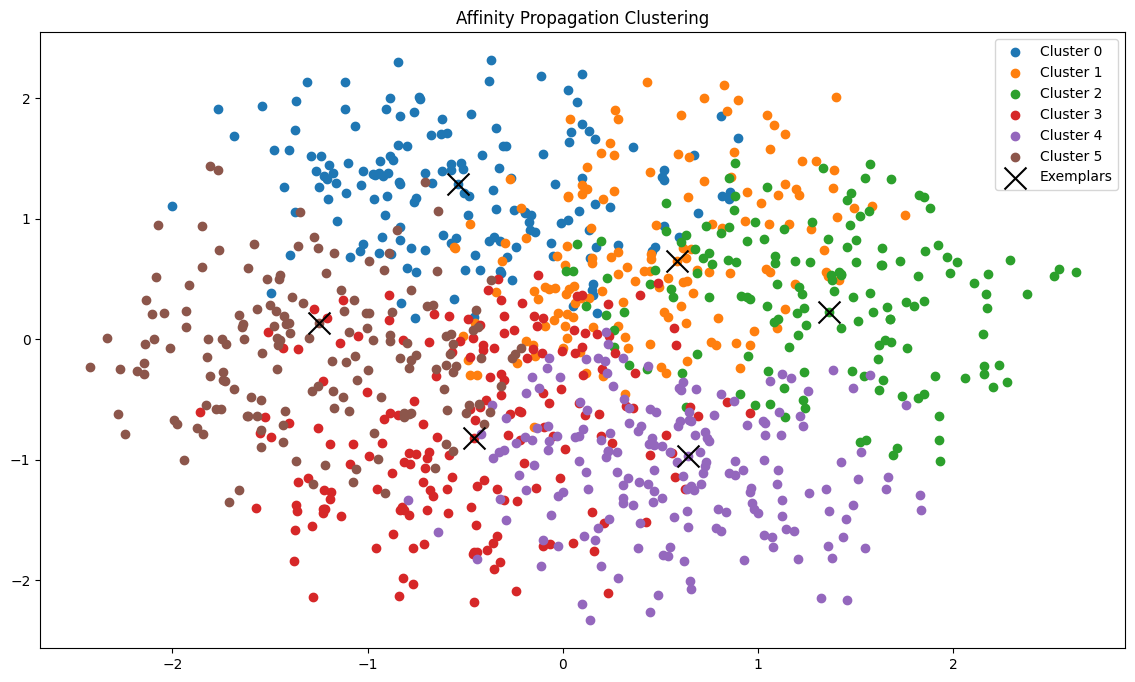

In [ ]:
labels = ap.labels_
exemplars = ap.cluster_centers_indices_

plt.figure(figsize=(14, 8))
for cluster in set(labels):
    plt.scatter(
        X_2d[labels == cluster, 0],
        X_2d[labels == cluster, 1],
        label=f"Cluster {cluster}",
    )
plt.scatter(
    X_2d[exemplars, 0],
    X_2d[exemplars, 1],
    c="black",
    marker="x",
    s=250,
    label="Exemplars",
    edgecolors="white",
)
plt.legend()
plt.title("Affinity Propagation Clustering")
plt.show()

# Tối ưu

## 1. Tính các giá trị có thể có của preference

In [ ]:
S = ap.affinity_matrix_ # Tính theo âm euclidean

q1 = np.quantile(S, 0.25)
q2 = np.quantile(S, 0.50)
q3 = np.quantile(S, 0.75)
min_s = np.min(S)
max_s = np.max(S)
std_s = np.std(S)
mean_s = np.mean(S)

print(f"Q1: {q1:.3f}")
print(f"Q2: {q2:.3f}")
print(f"Q3: {q3:.3f}")
print(f"Min: {min_s:.3f}")
print(f"Max: {max_s:.3f}")
print(f"Mean: {mean_s:.3f}")
print(f"Std: {std_s:.3f}")

Q1: -8.878
Q2: -5.700
Q3: -3.216
Min: -97.959
Max: -0.000
Mean: -6.483
Std: 4.965


# Hyperparameter Optimization

### 1. Grid Search

In [ ]:
param_grid = {
    'damping': np.linspace(0.5, 0.9, 5),
    'preference': np.linspace(-500, 0, 20)
}

grid = ParameterGrid(param_grid)

best_score = -1
best_params = None
best_model = None
best_n_clusters = None

for params in grid:
    model = AffinityPropagation(
        damping=params['damping'],
        preference=params['preference'],
        random_state=42
        )
    labels = model.fit_predict(X)

    n_clusters = len(set(labels))
    if n_clusters <= 1 or n_clusters >= len(X):
        continue  # Bỏ qua trường hợp không hợp lệ

    score = silhouette_score(X, labels)

    if score > best_score:
        best_score = score
        best_params = params
        best_model = model
        best_n_clusters = n_clusters

print("\nKết quả tốt nhất từ Grid Search:")
print(f"- Damping: {best_params['damping']:.3f}")
print(f"- Preference: {best_params['preference']:.3f}")
print(f"- Số lượng cụm: {best_n_clusters}")
print(f"- Silhouette Score: {best_score:.3f}")


Kết quả tốt nhất từ Grid Search:
- Damping: 0.900
- Preference: -236.842
- Số lượng cụm: 6
- Silhouette Score: 0.236


### 2. Hyperopt / Optuna